In [6]:
# ==========================================================
# 1️⃣ Import Libraries
# ==========================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from cassandra.cluster import Cluster
from datetime import datetime
import time

# 🚨 ต้องมีไฟล์ detect_wyckoff.py ใน directory เดียวกัน
from detect_wyckoff import detect_wyckoff_events

# ==========================================================
# 2️⃣ ฟังก์ชันดึงข้อมูลจาก Cassandra (แก้ไข SELECT Query)
# ==========================================================
def get_candlestick_data(symbol: str, days: int = 30) -> pd.DataFrame:
    """ดึงข้อมูลราคาและ Volume จาก Cassandra"""
    
    # ⚠️ ตรวจสอบว่า Cassandra Server ได้รันอยู่ (127.0.0.1:9042)
    cluster = Cluster(['127.0.0.1'], port=9042)
    session = cluster.connect('data_stock')
    
    end_time = datetime.now()
    start_time = end_time - pd.Timedelta(days=days)
    
    # 🚨 แก้ไข: ใช้ ALIAS ใน CQL query เพื่อเลือกคอลัมน์ที่ถูกต้อง (open_price) 
    # และเปลี่ยนชื่อให้เป็นชื่อสั้น (open) ที่ detect_wyckoff_events ต้องการ
    query = f"""
    SELECT time, open_price AS open, high_price AS high, low_price AS low, close_price AS close, volume 
    FROM candlestick_data 
    WHERE symbol = '{symbol}' AND time >= %s ALLOW FILTERING;
    """
    
    rows = session.execute(query, [start_time])
    
    df = pd.DataFrame(list(rows))
    if df.empty:
        raise ValueError(f"ไม่พบข้อมูลสำหรับสัญลักษณ์ '{symbol}' ในช่วง {days} วัน")
        
    # จัดการข้อมูล: ตั้งค่า Index
    df.set_index('time', inplace=True)
    df.index = pd.to_datetime(df.index)
    
    # 🚨 ยกเลิกการ rename ที่ซ้ำซ้อน เพราะใช้ ALIAS ใน query แล้ว
    
    return df.sort_index()

In [7]:
# ==========================================================
# 3️⃣ ฟังก์ชันวาดกราฟ Candlestick และ Wyckoff Events (ปรับปรุง)
# ==========================================================
def plot_wyckoff_events(df: pd.DataFrame, events: dict, symbol: str):
    
    fig, ax = plt.subplots(figsize=(18, 9))
    
    # 🔸 1. วาดราคาปิด (Price Plot) - ใช้ 'close' แทน 'close_price'
    ax.plot(df.index, df['close'], label='Price (Close)', color='skyblue', linewidth=1.5)
    
    # 🔸 2. วาดจุดเหตุการณ์สำคัญ Wyckoff
    
    # คำนวณ offset โดยใช้ High/Low จากคอลัมน์ใหม่
    annotation_offset = (df['high'].max() - df['low'].min()) * 0.01 
    marker_style = {'marker': 'o', 'markersize': 10, 'markerfacecolor': 'none', 'markeredgewidth': 2}
    
    # SC (Selling Climax)
    for idx in events['SC']:
        time_point = df.index[idx]
        price_point = df['low'].iloc[idx] # ใช้ 'low' แทน 'low_price'
        ax.plot(time_point, price_point, **marker_style, markeredgecolor='green', label='SC' if 'SC' not in ax.get_legend_handles_labels()[1] else '')
        ax.annotate('SC', (time_point, price_point - annotation_offset), color='green', fontsize=12, fontweight='bold', ha='center', va='top')

    # BC (Buying Climax)
    for idx in events['BC']:
        time_point = df.index[idx]
        price_point = df['high'].iloc[idx] # ใช้ 'high' แทน 'high_price'
        ax.plot(time_point, price_point, **marker_style, markeredgecolor='red', label='BC' if 'BC' not in ax.get_legend_handles_labels()[1] else '')
        ax.annotate('BC', (time_point, price_point + annotation_offset), color='red', fontsize=12, fontweight='bold', ha='center', va='bottom')
        
    # Spring (Bear Trap)
    for idx in events['Spring']:
        time_point = df.index[idx]
        price_point = df['low'].iloc[idx] # ใช้ 'low'
        ax.plot(time_point, price_point, **marker_style, markeredgecolor='purple', linestyle='--', label='Spring' if 'Spring' not in ax.get_legend_handles_labels()[1] else '')
        ax.annotate('Spring', (time_point, price_point - annotation_offset), color='purple', fontsize=12, fontweight='bold', ha='center', va='top')

    # UTAD (Bull Trap)
    for idx in events['UTAD']:
        time_point = df.index[idx]
        price_point = df['high'].iloc[idx] # ใช้ 'high'
        ax.plot(time_point, price_point, **marker_style, markeredgecolor='orange', linestyle='--', label='UTAD' if 'UTAD' not in ax.get_legend_handles_labels()[1] else '')
        ax.annotate('UTAD', (time_point, price_point + annotation_offset), color='orange', fontsize=12, fontweight='bold', ha='center', va='bottom')

    # 🔸 3. การจัดรูปแบบกราฟ
    ax.set_title(f'Wyckoff Events Detection for {symbol}', fontsize=16)
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # จัด format แกน X
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

✅ ดึงข้อมูล AOT ได้ 60 แถว

--- 📝 สรุป Wyckoff Events ที่พบ ---
BC (Buying Climax): 1 จุด
SC (Selling Climax): 1 จุด
UTAD (Bull Trap): 0 จุด
Spring (Bear Trap): 0 จุด


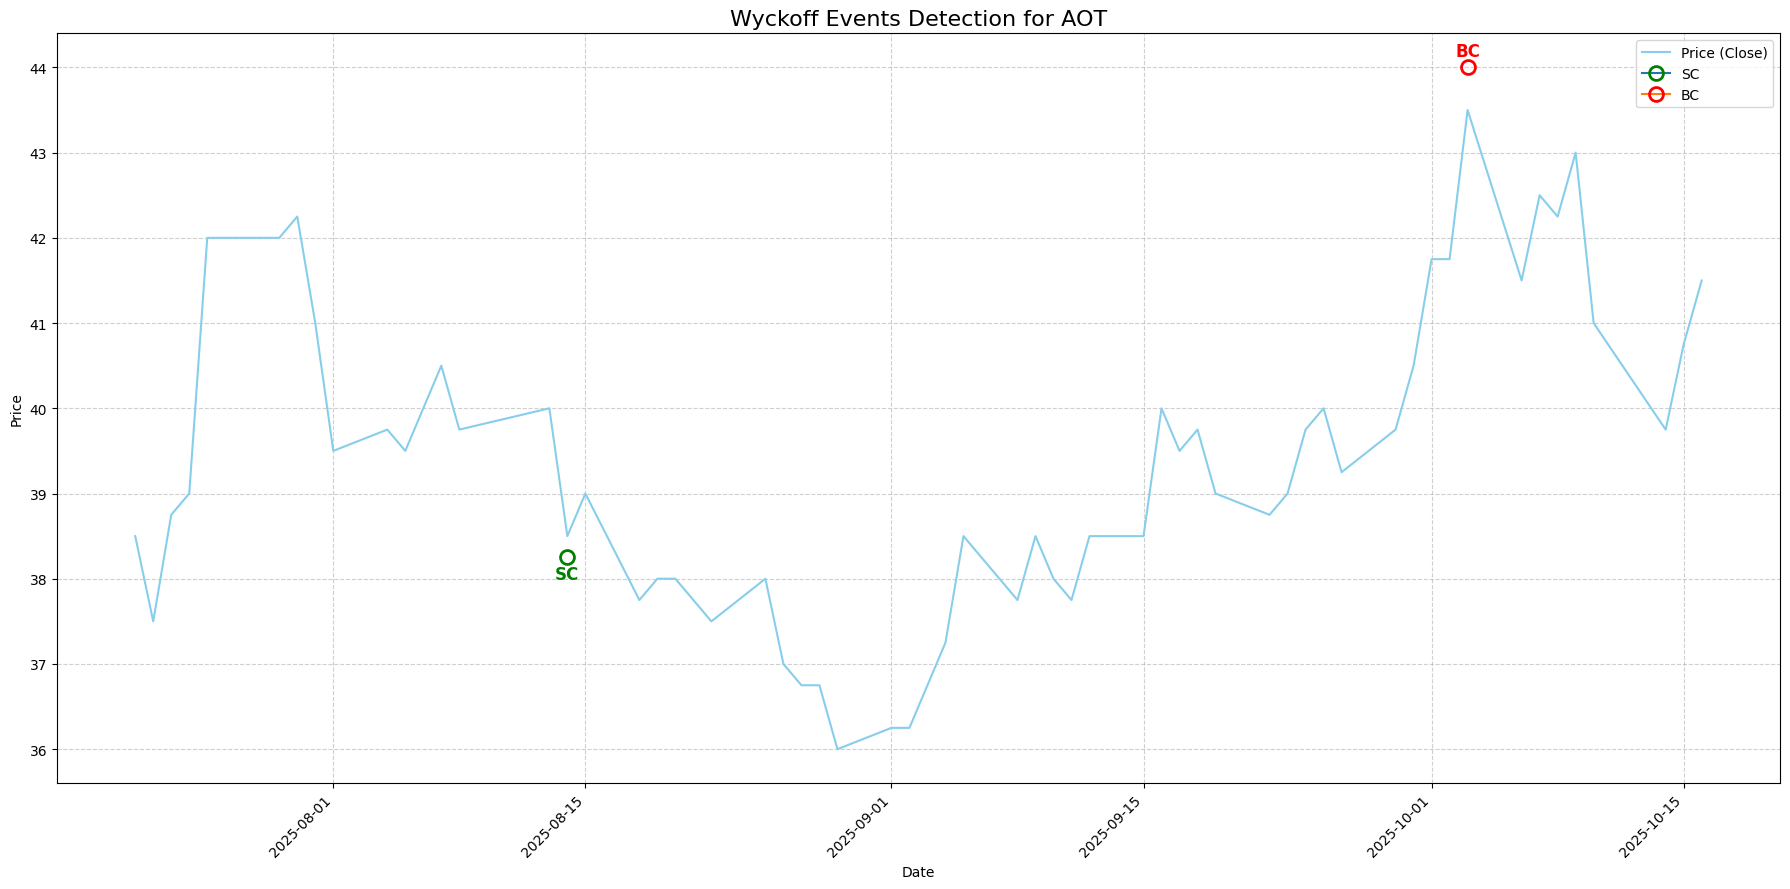

In [8]:
# ==========================================================
# 4️⃣ Main Execution (ปรับปรุง)
# ==========================================================
if __name__ == '__main__':
    
    STOCK_SYMBOL = 'AOT'  # ⬅️ เปลี่ยนสัญลักษณ์หุ้นที่ต้องการ
    DAYS_LOOKBACK = 90    # ⬅️ ช่วงวันย้อนหลังที่ต้องการวิเคราะห์
    VOLUME_PERCENTILE = 0.90 # ⬅️ เกณฑ์ Volume สำหรับ Climax (0.90 = 10% ที่สูงที่สุด)

    try:
        # 1. ดึงข้อมูล
        df_data = get_candlestick_data(STOCK_SYMBOL, DAYS_LOOKBACK)
        print(f"✅ ดึงข้อมูล {STOCK_SYMBOL} ได้ {len(df_data)} แถว")
        
        # 2. ตรวจจับ Wyckoff Events
        # 🚨 ไม่ต้องมีการ rename อีก เพราะ df_data มีคอลัมน์ 'close', 'high', 'low' แล้ว
        wyckoff_events = detect_wyckoff_events(
            df_data, 
            price_distance=5, 
            volume_percentile=VOLUME_PERCENTILE
        )
        
        # 3. แสดงผลลัพธ์
        print("\n--- 📝 สรุป Wyckoff Events ที่พบ ---")
        print(f"BC (Buying Climax): {len(wyckoff_events['BC'])} จุด")
        print(f"SC (Selling Climax): {len(wyckoff_events['SC'])} จุด")
        print(f"UTAD (Bull Trap): {len(wyckoff_events['UTAD'])} จุด")
        print(f"Spring (Bear Trap): {len(wyckoff_events['Spring'])} จุด")
        
        # 4. วาดกราฟ
        plot_wyckoff_events(df_data, wyckoff_events, STOCK_SYMBOL)
        
    except ValueError as e:
        print(f"\n❌ ข้อผิดพลาดข้อมูล: {e}")
    except Exception as e:
        print(f"\n❌ เกิดข้อผิดพลาดที่ไม่คาดคิด: {e}")